# Trabalho de casa 02: Regressão linear

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'.

## Exercícios computacionais

**Exercício 1.** Deixamos à sua disposição o dataset ["California Housing"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), dividio em treino, teste e validação.
O modelo que você utilizará para aproximar a relação funcional entre as features e as labels é o modelo linear, i.e., $\mathbf{y} = X\theta$.
Entretanto, você deve estimar seus parâmetros (minimizando o *mean squared error*) com **dois algoritmos diferentes**.
Uma implementação deve estimar $\theta$ por meio de **Stochastic Gradient Descent (SGD)** e, a outra, por meio de **Ordinary Least Squares (OLS)**, ou seja, utilizar a solução em fórmula fechada vista em aula.

Para o SGD, o ponto inicial deve ser escolhido aleatoriamente e o algoritmo deve parar quando a norma da diferença entre duas estimativas consecutivas de $\theta$ for menor do que um $\varepsilon > 0$ previamente especificado.
Para o experimento a seguir, fixe $\varepsilon$ em um valor pequeno (por exemplo, alguma potência de $1/10$) para a qual o algoritmo convirja no máximo em alguns minutos para uma solução com perda pequena.

Para diferentes tamanhos de minibatch (por exemplo $\{2^{j}: 1 \leq j \leq 7\}$), plote um gráfico representando o valor da perda $ L(\hat{\theta}) = \frac{1}{n} \lVert X \hat{\theta} - \mathbf{y} \rVert^{2}$ no conjunto de validação em função do número de epochs. Mostre também o valor ótimo obtido com OLS. Comente os resultados e o efeito tamanho do mini-batch, e.g., no tempo de treinamento. Reporte valores nos conjuntos de treino, validação e teste.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)


features, labels = fetch_california_housing(return_X_y=True)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25
)

features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=0.25
)

In [2]:
class LinearRegression(): # using y = X.dot(theta)
    
    def __init__(self, learning_rate=1e-8, batch_size=32, optimization="SGD", epsilon=1e-7):
        self.theta = None
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.optimization = optimization
        self.epsilon = epsilon
        
    def fit(self, features, labels): # features: X (n_samples, n_features), labels: y (n_samples, 1)
        self.features = features
        self.labels = labels
        
        if self.optimization == "SGD": # Stochastic Gradient Descent
            
            # add bias to the features matrix
            features = np.hstack((np.ones((features.shape[0], 1)), features))
            
            # initialize theta randomized
            self.theta = np.random.normal(scale = 1e-4, size = (features.shape[1], 1))
            
            labels = self.labels.reshape(-1, 1)
            
            epoch = 0
            self.thetas = [] # set an empty list to store the errors
            
            while True:
                
                # shuffle the data getting batch_size samples randomly
                idx = np.random.choice(features.shape[0], self.batch_size)
                features_batch = features[idx]
                labels_batch = labels[idx]
                
                # calculate the gradient 
                gradient = 2 * features_batch.T.dot(features_batch.dot(self.theta) - labels_batch) / self.batch_size
                
                # set previous theta
                theta_old = self.theta
                    
                # update theta using the gradient
                self.theta = self.theta - self.learning_rate * gradient
                self.thetas.append(self.theta)
                
                epoch = epoch + 1
                
                # end the loop when a norm of two consecutive estimates of theta is less than epsilon
                if np.linalg.norm(self.theta - theta_old) < self.epsilon:
                    break
            
        elif self.optimization == "OLS": # Ordinary Least Squares
            # add bias to the features matrix
            features = np.hstack((np.ones((features.shape[0], 1)), features))
            
            # X^T * X * theta = X^T * y => theta = (X^T * X)^-1 * X^T * y
            self.theta = np.linalg.inv(features.T.dot(features)).dot(features.T).dot(self.labels)
        
    def predict(self, features):
        # add bias to the features matrix
        features = np.hstack((np.ones((features.shape[0], 1)), features))
        return features.dot(self.theta)

In [3]:
SGD = LinearRegression(optimization="SGD")
SGD.fit(features_train, labels_train)
pred_validation = SGD.predict(features_validation)

print('MSE:' , np.mean((pred_validation - labels_validation.reshape(-1, 1)) ** 2))

MSE: 1.5037837481934173


In [4]:
pred_test = SGD.predict(features_test)

print('MSE:' , np.mean((pred_test - labels_test.reshape(-1, 1)) ** 2))

MSE: 1.4633838334540954


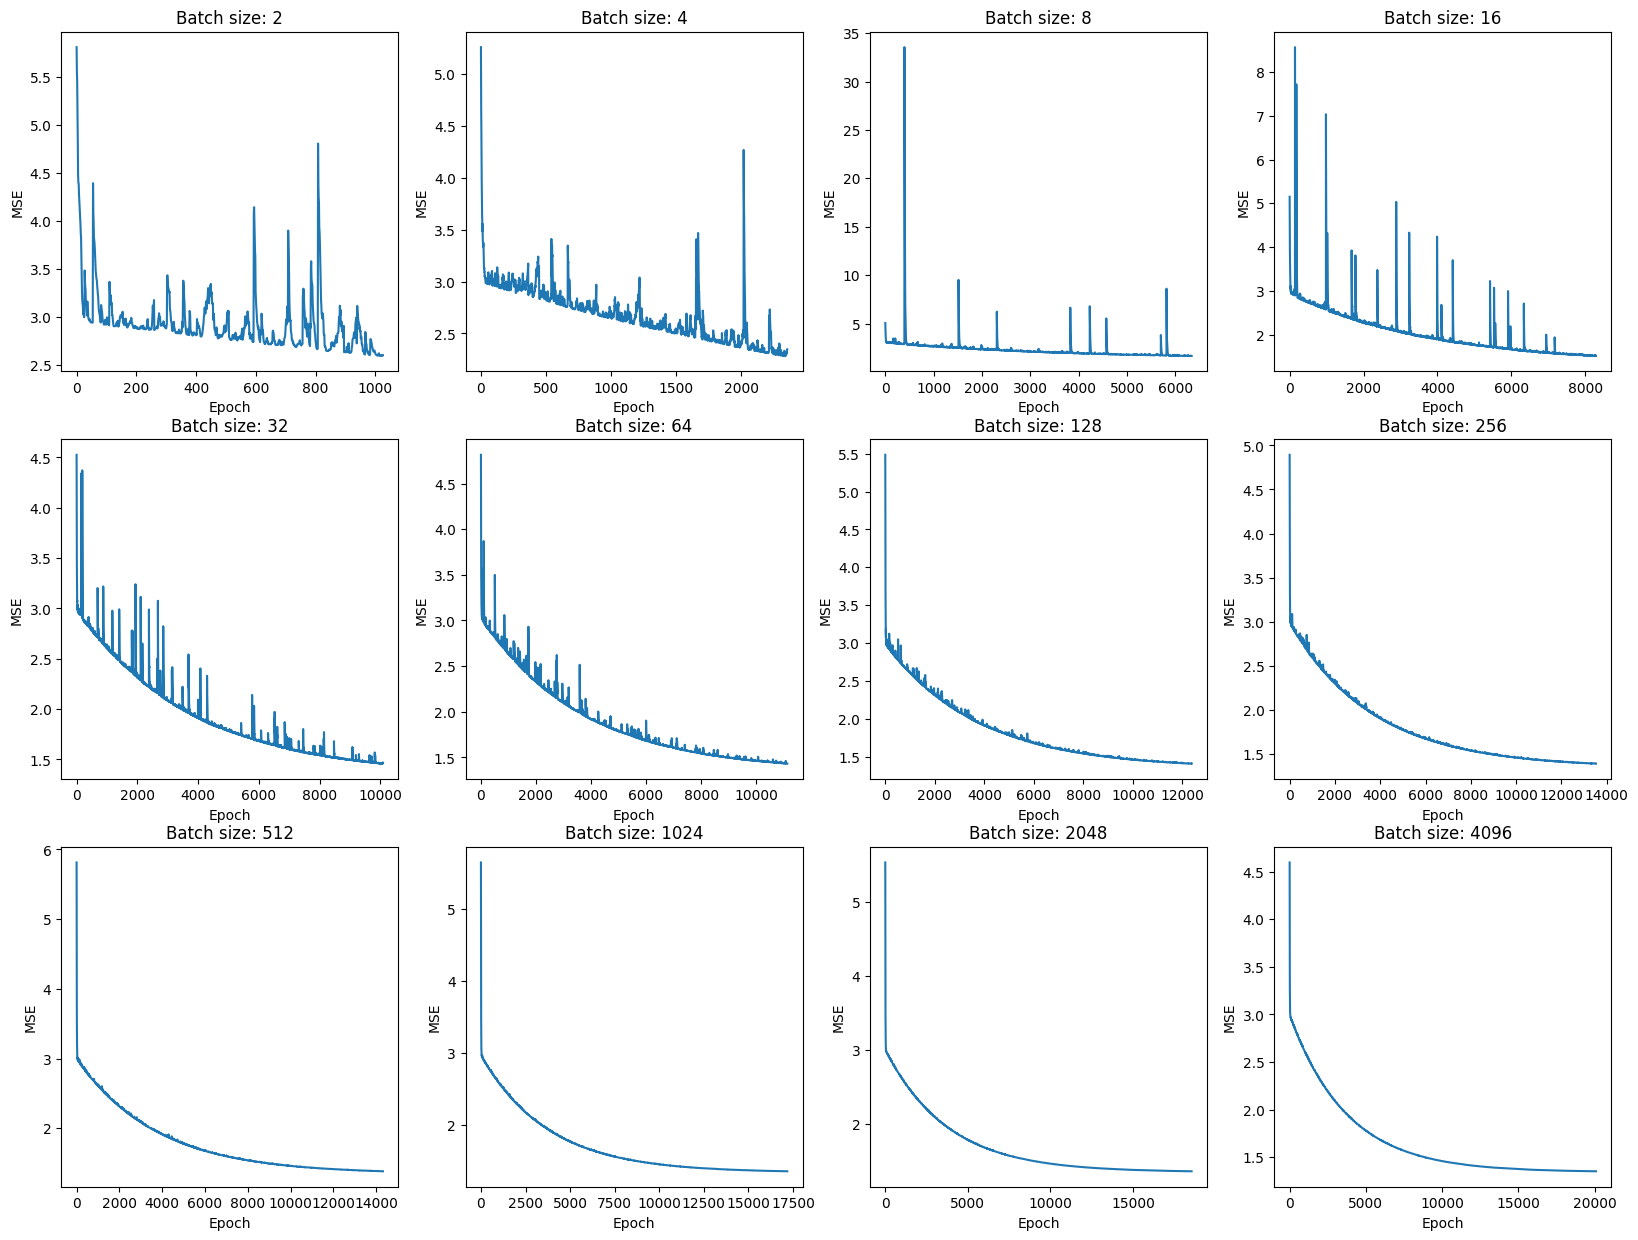

In [5]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(20, 15))

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    model = LinearRegression(optimization="SGD", batch_size=2**i)
    model.fit(features_train, labels_train)
    
    squared_errors = []
    
    X_validation = np.hstack((np.ones((features_validation.shape[0], 1)), features_validation))
    
    # use the weights on the thetas list (trained with training sets) to calculate the error on the validation set
    for j in range(len(model.thetas)):
        error = np.mean((X_validation.dot(model.thetas[j]) - labels_validation.reshape(-1, 1)) ** 2)
        squared_errors.append(error)
    
    ax = f.add_subplot(3, 4, i)
    ax.plot(squared_errors)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.set_title('Batch size: {}'.format(2**i))
    
plt.show()

A tendência, de forma geral, é de queda no valor do MSE conforme aumenta o número de iterações. O tamanho das batches, nesse caso, tem um efeito claro: conforme o tamanho aumenta, menor é a variação do erro - afinal, as iterações são realizadas passando por um volume maior de dados. **Isto é, conforme o tamanho do batch aumenta, mais lisa é a curva de queda do MSE.** 

No que diz respeito ao tempo de treinamento, observe, por exemplo, que quanto maior é o tamanho do batch, maior é o número de iterações realizado pelo modelo para realizar a predição. Ainda que a correlação entre tempo de treinamento e número de iterações seja imediata, de fato, o tamanho do batch fez aumentar o tempo necessário para o modelo realizar predições.

In [6]:
OLS = LinearRegression(optimization="OLS")
OLS.fit(features_train, labels_train)

theta = OLS.theta

X_validation = np.hstack((np.ones((features_validation.shape[0], 1)), features_validation))

print('MSE:', np.mean((X_validation.dot(theta) - labels_validation.reshape(-1, 1)) ** 2))

MSE: 2.204958087295769


O tempo de execução do OLS, também por ser um método com forma fechada (e, portanto, não envolve iteração), é muito mais rápido no caso dos dados utilizados no problema. Isso tem a ver com o fato de que o conjunto de dados não é tão grande, o que facilita o uso de métodos com essa característica. Observe, no entanto, que o SGD com os hiperparâmetros definidos na classe implementada obtiveram predições (com relação ao conjunto de teste e validação) menores que o observado no OLS.

**Exercício 2.** Agora, você deve implementar uma **Rede RBF** com função de base Gaussiana (veja as notas de aula).
Para os centróides, utilize o output de um modelo de clusterização por K médias, por meio da função que disponibilizamos, como a seguir:

In [7]:
def k_means_factory(n_clusters: int) -> KMeans:
    return KMeans(n_clusters=n_clusters, n_init="auto")

k_means_model = k_means_factory(n_clusters=2)
dumb_data = np.array(
    [[1, 2],
     [1, 4],
     [1, 0],
     [10, 2],
     [10, 4],
     [10, 0]]
)
k_means_model.fit(dumb_data)    
cluster_centers = k_means_model.cluster_centers_
print(cluster_centers) # Shape (n_clusters, n_features)

[[10.  2.]
 [ 1.  2.]]


Para determinar o melhor valor de $k$ para o algoritmo de clusterização, treine o modelo (usando a fórmula de OLS) com diferentes valores e escolha o que possuir o menor erro de validação. Faça um gráfico mostrando o valor do erro de validação para diferentes valores de $k$. Mostre também a performance do modelo escolhido no conjunto de teste. Compare com o modelo linear simples da questão anterior. Discuta os resultados.

Para definir o valor do hiper-parâmetro $\gamma$, use a seguinte heurística --- que pode ser achado no livro "Neural Networks", por Simon Haykin:

$$
\gamma = \frac{1}{d_\text{max}^2},
$$

onde $d_\text{max}$ é a maior distância entre um par de centróides. Note que o valor costuma mudar para $k$'s diferentes.


In [8]:
# radial basis function
def rbf_func(x, c, max_distance):
    gamma = 1 / ((max_distance ** 2))
    # c é o centro do cluster
    return np.exp((-np.linalg.norm(x - c) ** 2) * gamma)

class RBF():
    
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters
        
    def fit(self, features, labels):
        self.features = features
        self.labels = labels
        
        # find centers using k-means
        k_means_model = k_means_factory(n_clusters=self.n_clusters)
        k_means_model.fit(features)
        cluster_centers = k_means_model.cluster_centers_
        
        # get the max distance between the cluster centers
        self.max_distance = np.max([np.linalg.norm(cluster_centers[i] - cluster_centers[j]) for i in range(self.n_clusters) for j in range(self.n_clusters)])
        
        self.features = np.hstack((np.ones((features.shape[0], 1)), features))
        self.labels = self.labels.reshape(-1, 1)
            
        # create a Z matrix with the radial basis function
        Z_train = np.zeros((features.shape[0], self.n_clusters))
        for i in range(features.shape[0]):
            for j in range(self.n_clusters):
                Z_train[i, j] = rbf_func(features[i], cluster_centers[j], self.max_distance)
        
        self.theta = np.linalg.inv(Z_train.T.dot(Z_train)).dot(Z_train.T).dot(self.labels)
        
    def predict(self, features):
        features = np.hstack((np.ones((features.shape[0], 1)), features))
        
        Z_predict = np.zeros((features.shape[0], self.n_clusters))
        for i in range(features.shape[0]):
            for j in range(self.n_clusters):
                Z_predict[i, j] = rbf_func(features[i], self.theta[j], self.max_distance)
        
        return Z_predict.dot(self.theta)

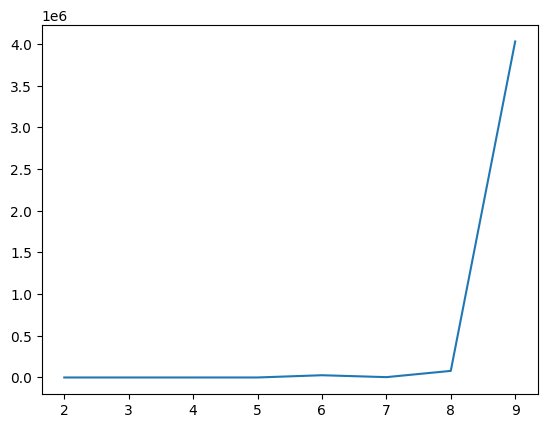

In [9]:
errors = []
for i in range(2, 10):
    RBF_ = RBF(n_clusters=i)
    RBF_.fit(features_train, labels_train)
    prediction = RBF_.predict(features_validation)

    errors.append(np.mean((prediction - labels_validation.reshape(-1, 1)) ** 2))

plt.plot(range(2, 10), errors)  

In [10]:
errors

[1.4501112264710834,
 2.8900592667441964,
 3.1728281721391642,
 50.134764993983474,
 26929.41957354011,
 4054.070795758635,
 78874.30700983752,
 4027884.7632542476]

# Exercícios de "papel e caneta"

**Exercício 1.** Deixe que $X \in \mathbb{R}^{N\times D}$, $c>0$ e $I$ denote a matriz identidade de dimensão $N$.
 Mostre que $X^\intercal X + c I$ possui inversa.

**Resposta**

Para mostrar que $X^T X + cI$ possui inversa, vamos avaliar se se trata de uma matriz definida positiva, que, por definição, possui inversa. Para isso, basta testar se:

$$a^T (X^T X + cI) a > 0$$

onde $a$ é um vetor não nulo por hipótese.

Aplicando a distributiva, obtemos $a^T X^T X a + c a^T a > 0$, que corrobora para que avaliemos a matriz como positiva definida. Na prática, $X^T X$ é naturalmente uma matriz simétrica e, portanto, semi-definida positiva, isto é, $a^T X^T X a$ é pelo menos 0. Quando somamos $c a^T a$, número necessariamente positivo, ao número que resulta de $a^T X^T X a$, chegamos a um número necessariamente maior do que 0, o que prova que $X^T X + cI$ é matriz positiva definida e, portanto, possui inversa.

**Exercício 2.** Deixe que $X \in \mathbb{R}^{N\times D}$ seja uma matriz contendo os exemplos de treinamento (um por linha) e que $y\in \mathbb{R}^N$ seja um vetor coluna os outputs observados para cada vetor de input em suas linhas. Na aula, derivamos a solução de mínimos quadrados ordinários (OLS). Use o mesmo raciocínio para resolver achar o vetor de pesos ${\theta}$ que minimiza:
 
$$ \|X \theta - y\|_2^2 + c \|\theta\|_2^2 $$

onde $c>0$ é uma constante.

**Resposta**

Segundo as notas de aula relativas a regressões lineares, se a matriz $X^T X$ for definida positiva, então a função de perda é estritamente convexa - isto é, ela possui um único mínimo global, que pode ser encontrado derivando a função e igualando-a a 0. Já provamos no item anterior que $X^\intercal X + c I$ é definida positiva, então vale a característica anteriormente mencionada para a função de perda da questão:

$$ \|X \theta - y\|_2^2 + c \|\theta\|_2^2 $$

Segue o processo de derivação da função de perda, obtendo $\theta$ que a minimiza. Os métodos de derivação de matrizes foram retirados do livro *The Matrix Cookbook*:

$$\frac{d((X \theta - y)^T (X \theta -y) + c \theta^T \theta)}{d \theta} = 2(X^TX \theta - X^T y) + 2c \theta$$

$$2(X^TX \theta - X^T y) + 2c \theta = 0 \Rightarrow (X^TX \theta - X^T y) + c \theta = 0$$

$$ (X^T X + c) \theta = X^T y \Rightarrow $$

$$\theta = (X^T X + c)^{-1} X^T y$$

**Exercício 3.** Em algumas situações, temos muito mais features que amostras ($D \gg N$). Esse tipo de cenário é comum, e.g., na análise de dados genômicos. Nesse caso, costumam existir infinitas combinações lineares das features que expressam o vetor de saídas $y$. Portanto, precisamos de algum critério para escolher um deles. Uma abordagem possível, é escolher o vetor de pesos $\theta$ que possua menor norma L2.

Com isso em mente, derive a solução que minimiza $\|\theta\|_2^2$ e respeita $X \theta = y$. Assuma que as linhas de $X$ são linearmente independentes

**Resposta**

A questão pede que encontremos $\theta$ que minimiza uma $f$, $\|\theta\|_2^2$ dada a restrição $g$, $X \theta = y$. Esse problema pode ser resolvido com a aplicação dos Multiplicadores de Lagrange, onde:

$$\Lambda (\theta, \lambda) = f - \lambda g = \theta^T \theta - \lambda (X \theta - y)$$

O processo é derivar parcialmente $\Lambda$ em relação a $\theta$ e $\lambda$, obtendo um sistema de duas equações (igualadas a 0) que permitirá obter uma expressão final para $\theta$ que minimiza $f$ sujeita a $g$. Segue:

$$\nabla(\Lambda) = (2 \theta - X^T \lambda^T, X \theta - y)$$

$$\begin{cases}
2 \theta - X^T \lambda^T = 0 \\
X \theta - y = 0
\end{cases}
$$

Isolando $\theta$ na primeira equação obtemos $\theta = \frac{X^T \lambda^T}{2}$. Sua substituição na segunda equação permite que obtenhamos uma expressão para $\lambda^T$, no caso, $2 (XX^T)^{-1}y$. Daí, retornando à expressão obtida para $\theta$, chegamos à expressão de $\theta$ que minimiza $f$ dada a restrição: 

$$\theta = X^T (XX^T)^{-1} y$$